# Intro

Last notebook we looked at the Auto ARIMA model which we ended up seeing returns a mean predicted value. This week we look at ARCH(p)/GARCH(p,q) models which aim to predict the variance of a time series. In addition, ARMA(p,q)/ARIMA(p,d,q) seek to predict the mean of a time series assuming 0 variance while the ARCH/GARCH models seek to predict the variance of a time series while assuming 0 mean. GARCH(p,q) stands for "Generalized AutoRegressive Conditional Heteroskedasticity" and the name stems from the ARCH Model which looks to predict variance based on previous squared errors. Time series can have a variance that is either heteroskedastic (changes over time) or homoskedastic (same over time). time-series that are heteroskedastic present "volatility clusters" when looking at the data. This will be further explained below, but simply put, there are groupings where spikes in variance seem to lead to further spikes. Lastly, the difference between ARCH(p) and GARCH(p,q) is that in the ARCH model the conditional variance depends on the previous squared errors, which are random, resulting in large swings in the variance prediction with each time step. However, the previous variance seems to persist in the real data for more than one time step, so GARCH(p,q) accounts for this by adding a q-term which determines how many previous variance terms to include for the variance prediction at each step.

Also be aware that volatility is the square root of variance ie. the standard deviation of returns.

# Get Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Get Data

In [2]:
# Get Stock Price Data
df = pd.read_csv(r"C:\Users\Aaron\Data Udemy\SPY.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,92.246048,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,92.490204,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,92.555328,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,92.946060,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,93.255348,126402800


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2263 entries, 2010-01-04 to 2018-12-28
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2263 non-null   float64
 1   High       2263 non-null   float64
 2   Low        2263 non-null   float64
 3   Close      2263 non-null   float64
 4   Adj Close  2263 non-null   float64
 5   Volume     2263 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.8 KB


In [4]:
# Get the log return
df['logPrice'] = np.log(df['Close'])
df['logRet'] = df['logPrice'].diff()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2263 entries, 2010-01-04 to 2018-12-28
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2263 non-null   float64
 1   High       2263 non-null   float64
 2   Low        2263 non-null   float64
 3   Close      2263 non-null   float64
 4   Adj Close  2263 non-null   float64
 5   Volume     2263 non-null   int64  
 6   logPrice   2263 non-null   float64
 7   logRet     2262 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 159.1 KB


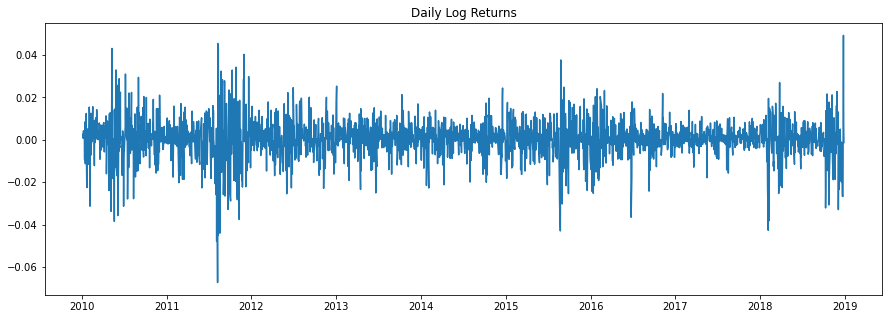

In [6]:
# Plot Log Returns
plt.figure(figsize=(15,5))
plt.plot(df['logRet'].dropna())
plt.title('Daily Log Returns')
plt.show()

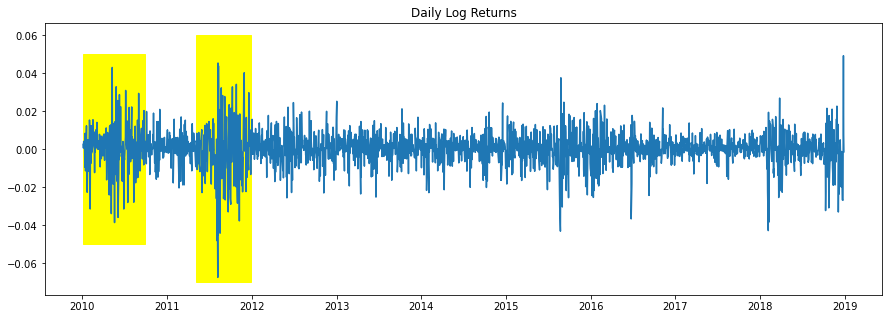

In [7]:
# Plot log returns and visualize volatility cluster

 # Set Params for Rectangle Dimensions
start1 = mdates.date2num("2010-01-04")
end1 = mdates.date2num("2010-09-30")
width1 = end1 - start1

# Draw Rectangle for First Cluster Example
rect1 = mpatches.Rectangle((float(start1),-0.05),width1,0.1, color='yellow')

# Set Params for Rectangle Dimensions
start2 = mdates.date2num("2011-05-04")
end2 = mdates.date2num("2011-12-30")
width2 = end2 - start2

# Draw Rectangle for Second Cluster Example
rect2 = mpatches.Rectangle((float(start2),-0.07),width2,0.13, color='yellow')

# Plot everything
plt.figure(figsize=(15,5))
plt.plot(df['logRet'])
plt.title('Daily Log Returns')
plt.gca().add_patch(rect1)
plt.gca().add_patch(rect2);




Volatility clustering is present in the log-returns where periods of high volatility lead to more high volatility and vice versa with low volatility. The ARCH/GARCH models use this property as the basis for being able to predict future variance based on past values.

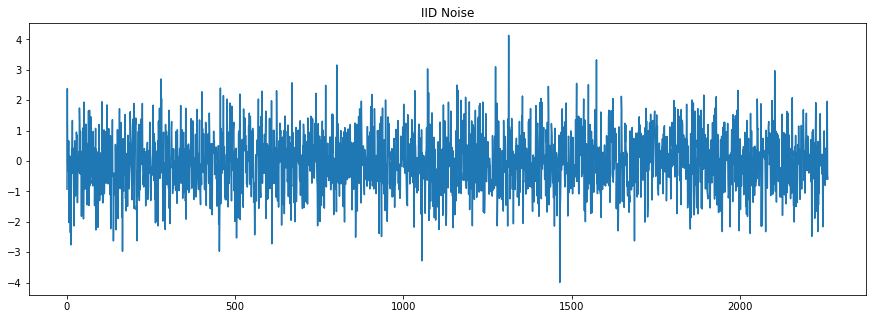

In [8]:
# Homoskedastic plot for reference
mean = 0.0
std = 1
noise = np.random.normal(mean, std, size = 2263)
plt.figure(figsize=(15,5))
plt.plot(noise)
plt.title('IID Noise')
plt.show();



IID noise, independent and indentically distributed. Variance of a homoskedastic time-series drawing from the random normal distribution with mean 0 and standard deviation of 1. No volatility clustering.

In [9]:
# Get the square of the log returns
df['Ysq'] = df['logRet'] ** 2

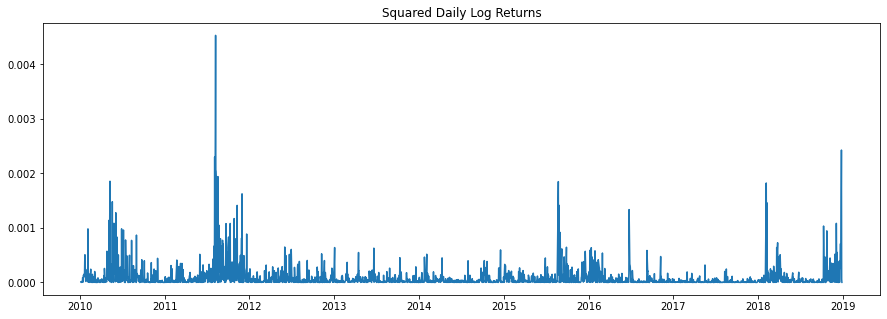

In [10]:
# visualize the clusters
plt.figure(figsize=(15,5))
plt.plot(df['Ysq'])
plt.title('Squared Daily Log Returns')
plt.show()

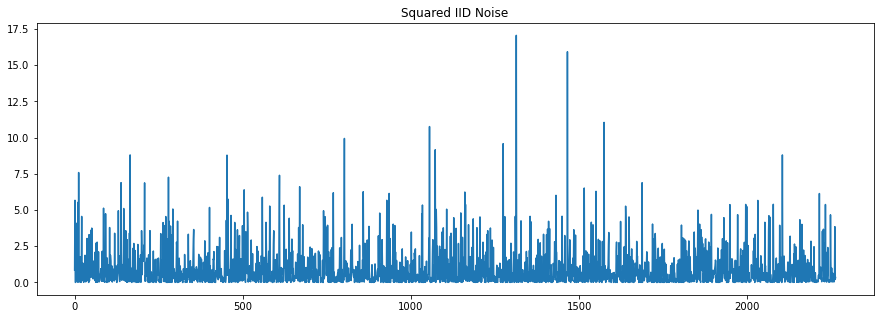

In [11]:
# Random IID noise squared
plt.figure(figsize=(15,5))
plt.plot(noise**2)
plt.title('Squared IID Noise')
plt.show()

Another view to visualize the heteroskedasticity of the log returns vs the homoskedasticity of random iid noise. 

# Checking for Stationarity/Autocorrelation/Partial autocorrelation

In [12]:
#Stationarity is an assumption of the ARCH/GARCH models
def adf(ts):
    adfResult = adfuller(ts)
    if adfResult[1] < 0.05:
        print(f" Pvalue = {adfResult[1]}. data is stationary")
    else:
        print('non-stationary')
    
adf(df['logRet'].dropna())

 Pvalue = 1.3368550654380464e-18. data is stationary


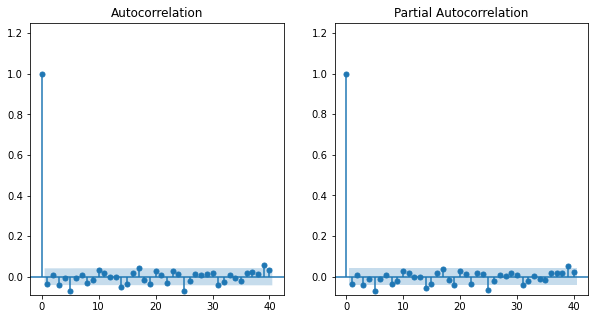

In [13]:
# ACF and PACF for log returns

def plot(ts):
    fig, ax = plt.subplots(1,2,figsize=(10,5))

    # Plot ACF
    sm.graphics.tsa.plot_acf(ts.squeeze(), 
                             lags=40, ax=ax[0],auto_ylims=True)
    # Plot PACF
    sm.graphics.tsa.plot_pacf(ts.squeeze(), 
                              lags=40, ax=ax[1],method='ywm',auto_ylims=True)
    plt.show()

plot(df['logRet'].dropna().values)

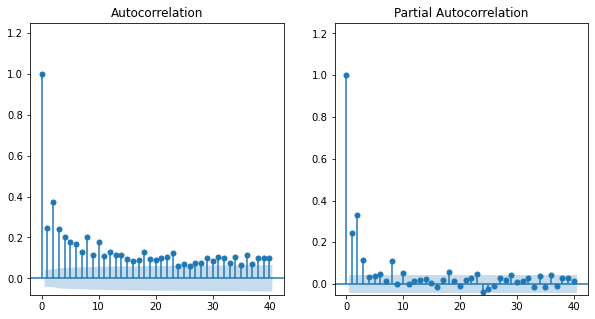

In [14]:
# ACF and PACF for Squared log returns

plot(df['Ysq'].dropna().values)

It appears that the squared log-returns have a significant lag structure in comparison to the normal log returns. Let's test to see if this occurs with random IID noise.

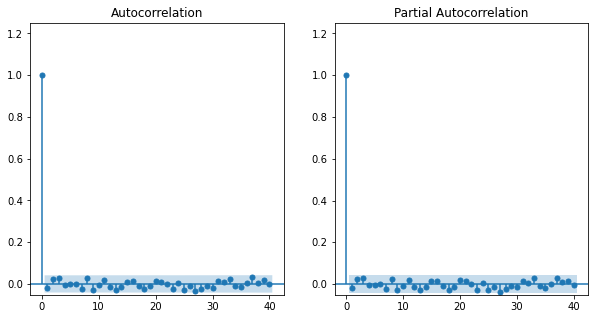

In [15]:
# ACF and PACF for random iid noise

plot(noise)

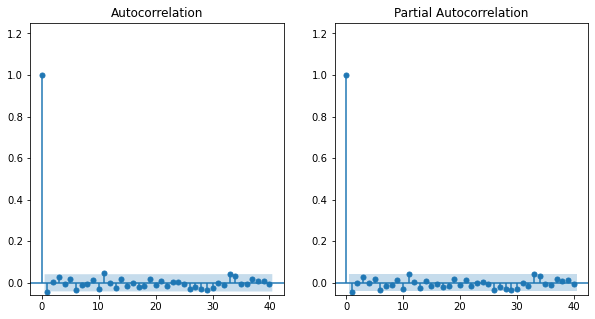

In [16]:
# ACF and PACF for squared random iid noise 

plot(noise**2)

The above shows the squared log-returns has significant lag values in comparison to squared noise. This is an important difference between Gaussian white noise/random walks and stock prices. In other words, taking the square of the returns uncovers autocorrelations and partial autocorrelations when the stock price data is transformed, however, true Gaussian noise values will never show a relationship regardless of the transformation.

# Prep train and test datasets

In [17]:
Ntest = 500 # Prediction horizon is 500 steps
train = df.iloc[:-Ntest][['logRet']].dropna().copy()
test = df.iloc[-Ntest:][['logRet']].dropna().copy()

In [18]:
# Time-series scaling is needed to avoid the issue seen below
model = arch_model(train['logRet'],vol='GARCH',p=1,q=1)
res = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 41389781493352.16
Iteration:      2,   Func. Count:     19,   Neg. LLF: 730871085210575.5
Iteration:      3,   Func. Count:     34,   Neg. LLF: 2251124839050.6025
Iteration:      4,   Func. Count:     47,   Neg. LLF: 293419607712405.06
Iteration:      5,   Func. Count:     62,   Neg. LLF: 922950509742.0027
Iteration:      6,   Func. Count:     75,   Neg. LLF: 3074097353677107.0
Iteration:      7,   Func. Count:     90,   Neg. LLF: 60238172561.980606
Iteration:      8,   Func. Count:    103,   Neg. LLF: 5518435606666360.0
Iteration:      9,   Func. Count:    118,   Neg. LLF: 155714862043.6356
Iteration:     10,   Func. Count:    130,   Neg. LLF: -5876.7012672053925
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5876.701269328093
            Iterations: 14
            Function evaluations: 130
            Gradient evaluations: 10


C:\Users\Aaron\anaconda3\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.532e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Warning that tell us our values are too small and model works better when values are between 1 and 1000.

In [19]:
# Scaling values by mean and standard deviation of training data
m = train['logRet'].mean()
s = train['logRet'].std()
train['Scaled'] = (train['logRet'] - m)/s
test['Scaled'] = (test['logRet'] - m)/s
df['Scaled'] = (df['logRet'] - m)/s

# ARCH(1) Model

In [20]:
arch1 = arch_model(train['Scaled'], vol='ARCH',p=1)
res_arch1 = arch1.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 73619.94901414218
Iteration:      2,   Func. Count:     13,   Neg. LLF: 3415.932590183317
Iteration:      3,   Func. Count:     20,   Neg. LLF: 2506.0209204251523
Iteration:      4,   Func. Count:     25,   Neg. LLF: 2457.9840699047827
Iteration:      5,   Func. Count:     29,   Neg. LLF: 2457.984028831308
Iteration:      6,   Func. Count:     32,   Neg. LLF: 2457.984028831369
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2457.984028831308
            Iterations: 6
            Function evaluations: 32
            Gradient evaluations: 6


In [21]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2457.98
Distribution:                  Normal   AIC:                           4921.97
Method:            Maximum Likelihood   BIC:                           4938.39
                                        No. Observations:                 1762
Date:                Sun, Jun 05 2022   Df Residuals:                     1761
Time:                        16:06:14   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0127  2.325e-02      0.545      0.586 [-3.291e-02,5.825e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.8188  6.722e-02     12.181  3.936e-34   [  0.687,  0.951]
alpha[1]       0.1771  4.774e-02      3.709  2.079e-04 [8.350e-02,  0.271]
==========================================================================

Covariance estimator: robust
"""

The above chart returns the metrics of how the model fits the data. Focusing on the second and third sections where we have the mean model and volatility model, we can see that the mean is close to zero however this result has a p-value greater than 0.05 so it is not significant. In the volatility model, the "omega"/bias term and "alpha[1]"/one-step lag squared error are both significant with p-values less than 0.05.

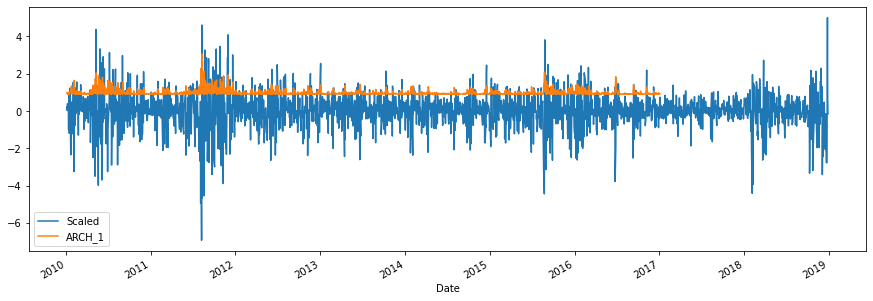

In [22]:
#Plot prediction of in-sample volatility
df['ARCH_1'] = res_arch1.conditional_volatility
df[['Scaled','ARCH_1']].plot(figsize=(15,5));

Compared to the scaled data the arch(1) model fit seems to underestimate those large swings in volatility in some areas and overestimate in other areas.

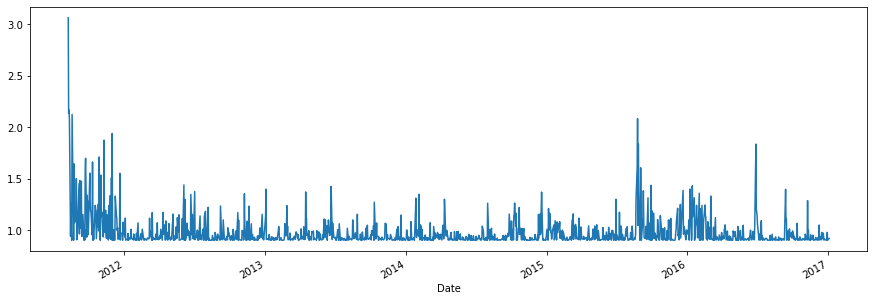

In [23]:
# Want to forecast out from this date
start_date = "2011-08-09"
df.loc[start_date:]['ARCH_1'].plot(figsize=(15,5));

In [24]:
# Call forecast function
fcast_arch1 = res_arch1.forecast(
        horizon=Ntest,reindex=True,start= start_date)

In [25]:
#Ensure horizon is consistent with value set above
fcast_arch1.variance.loc[start_date].to_numpy().shape

(500,)

In [26]:
# Get index of chosen start date
start_date_loc = df.index.get_loc(start_date)
print(start_date_loc)

403


In [27]:
# Get index of 500 days after start date
end_date = df.index[start_date_loc + Ntest]
print(end_date)

# Start date plus one
start_plus_one = pd.to_datetime(start_date) + pd.DateOffset(days=1)
print(pd.to_datetime(start_date) + pd.DateOffset(days=1))

2013-08-06 00:00:00
2011-08-10 00:00:00


In [28]:
# Add forecast to dataframe and create column for forecast
df.loc[start_plus_one:end_date,'ARCH_1_FORECAST'] = np.sqrt(
    fcast_arch1.variance.loc[start_date].to_numpy())

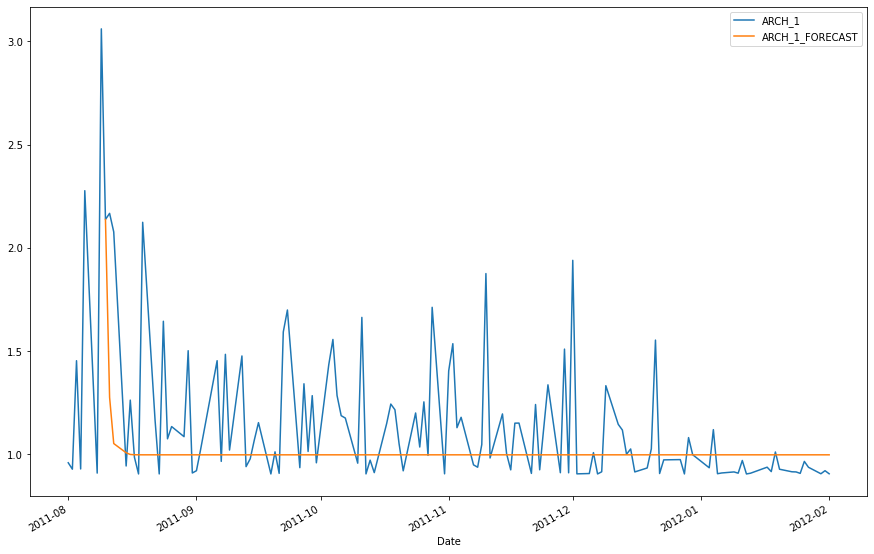

In [29]:
# Plot Forecast against predicted conditional volatility
df.loc['2011-08-01':'2012-02-01'][['ARCH_1','ARCH_1_FORECAST']].plot(
    figsize=(15,10));

Value starts high and then coverges quite quickly to the "unconditional variance" ie what the long-term predicted variance will be. The value also seems to underestimate the volatility for the most part.

In [30]:
# Getting the model params
print(res_arch1.params)

# Compare to the unconditional variance ie the converged value
print(f"unconditional variance: {res_arch1.params['omega'] / (1-res_arch1.params['alpha[1]'])}")

mu          0.012671
omega       0.818829
alpha[1]    0.177065
Name: params, dtype: float64
unconditional variance: 0.9950100818261426


# GARCH(2,2) Model

In [31]:
garch22 = arch_model(train['Scaled'], vol='GARCH',p=2,q=2)
res_garch22 = garch22.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 368610929468.40784
Iteration:      2,   Func. Count:     19,   Neg. LLF: 966343042.4228215
Iteration:      3,   Func. Count:     28,   Neg. LLF: 3096.717808086348
Iteration:      4,   Func. Count:     36,   Neg. LLF: 2461.312999167715
Iteration:      5,   Func. Count:     44,   Neg. LLF: 2333.2064124033955
Iteration:      6,   Func. Count:     52,   Neg. LLF: 2515.09052017636
Iteration:      7,   Func. Count:     61,   Neg. LLF: 2273.167122282367
Iteration:      8,   Func. Count:     69,   Neg. LLF: 2264.750167694787
Iteration:      9,   Func. Count:     77,   Neg. LLF: 2264.8309966635834
Iteration:     10,   Func. Count:     85,   Neg. LLF: 2264.348614746084
Iteration:     11,   Func. Count:     92,   Neg. LLF: 2264.348550467961
Iteration:     12,   Func. Count:     99,   Neg. LLF: 2264.3485494865145
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2264.3485494865145
            Iterations: 

In [32]:
res_garch22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2264.35
Distribution:                  Normal   AIC:                           4540.70
Method:            Maximum Likelihood   BIC:                           4573.54
                                        No. Observations:                 1762
Date:                Sun, Jun 05 2022   Df Residuals:                     1761
Time:                        16:06:19   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0282  1.856e-02      1.518      0.129 [-8.195e-03,6.456e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0781  2.077e-02      3.762  1.684e-04  [3.744e-02,  0.119]
alpha[1]       0.0814  3.798e-02      2.142  3.220e-02  [6.912e-03,  0.156]
alpha[2]       0.1523  4.596e-02      3.315  9.174e-04  [6.227e-02,  0.242]
beta[1]        0.3753      0.227      1.650  9.886e-02 [-7.039e-02,  0.821]
beta[2]        0.3093      0.187      1.655  9.797e-02 [-5.704e-02,  0.676]
===========================================================================

Covariance estimator: robust
"""

The Mean Model value for mu is again close to 0, as expected, although it is still not significant. The Volatility Model for the GARCH(2,2) has all significant coefficients for the omega/bias term, the alpha/previous squared error terms, and the previous beta/variance terms.

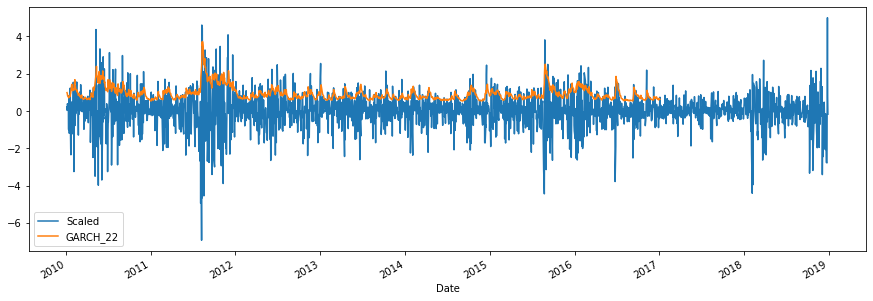

In [33]:
#Plot prediction of in-sample conditional volatility
df['GARCH_22'] = res_garch22.conditional_volatility
df[['Scaled','GARCH_22']].plot(figsize=(15,5));

Seems to fit in-sample data better than the ARCH(1) model.

In [34]:
# Generate the forecast for the same dates as the ARCH 1 model

# Forecast from start date
fcast_garch22 = res_garch22.forecast(
        horizon=Ntest,reindex=True,start= start_date)

#Get Index for start date
start_date_loc = df.index.get_loc(start_date)

#Get Index for end date = start date + 500 days
end_date = df.index[start_date_loc + Ntest]

# Start day plus one
start_plus_one = pd.to_datetime(start_date) + pd.DateOffset(days=1)


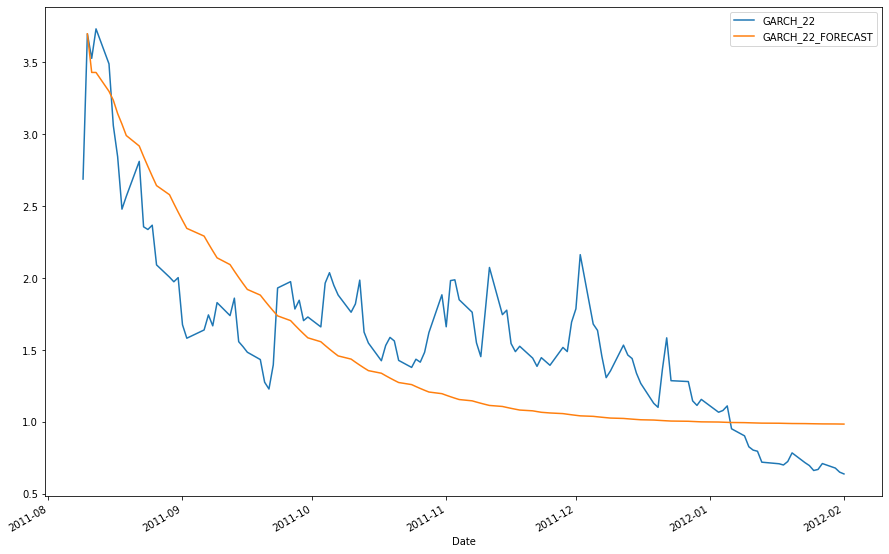

In [35]:
# Generate Column in dataframe for GARCH(2,2) Forecast
df.loc[start_plus_one:end_date,'GARCH_22_FORECAST'] = np.sqrt(
    fcast_garch22.variance.loc[start_date].to_numpy())

# Plot Forecast against predicted conditional volatility
df.loc[start_date:'2012-02-01'][['GARCH_22','GARCH_22_FORECAST']].plot(figsize=(15,10));


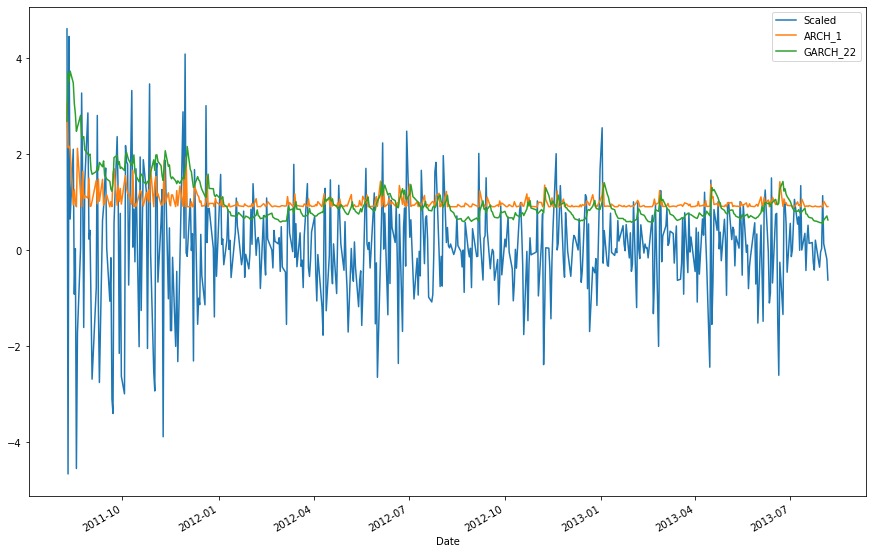

In [36]:
# Plot conditional volatility of ARCH(1) AND GARCH(2,2) Against Scaled Data
df.loc[start_date:end_date][['Scaled','ARCH_1','GARCH_22']].plot(
    figsize=(15,10));

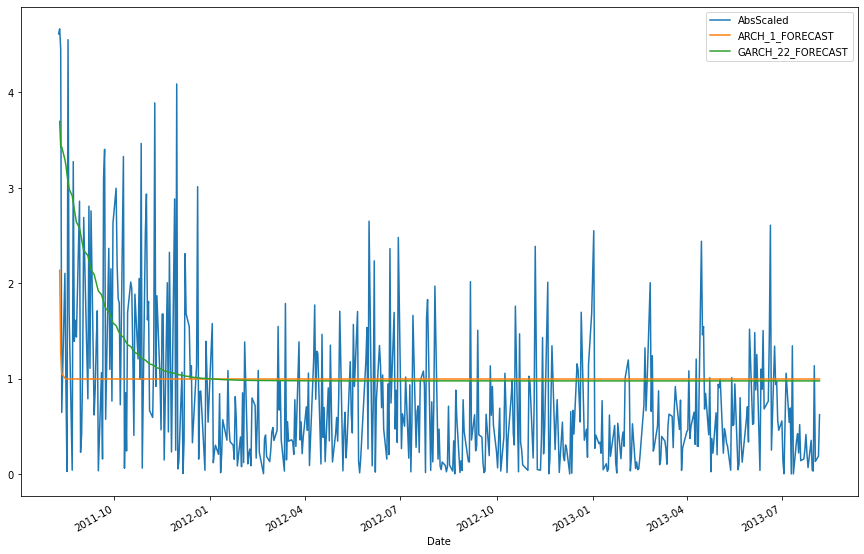

In [37]:
df['AbsScaled'] = df['Scaled'].abs()
df.loc[start_date:end_date][['AbsScaled','ARCH_1_FORECAST','GARCH_22_FORECAST']].plot(
    figsize=(15,10));

The GARCH(2,2) Volatility forecast appears to predict the short-term volatility more accurately than the ARCH(1), but we can also see that both models converge at the unconditional variance. 

# Additional Commentary

1) As you may have noticed this model does not output r-squared values, however using deep learning and a custom loss function we could train a variance prediction model using similar ideas to ARCH/GARCH. I may try this in the future using a neural network and a custom loss function.

2) Predicting volatility/variance could be useful as input into other models that assume static/constant variance. One such use case can be found in finance when pricing options contracts using the black scholes model. Another such model, which somewhat inspired the example below, is "Value at Risk" which in finance is used to estimate a portfolio's potential loss and the probability of those loses. 

# What Not To Do

The idea was to use GARCH so that "VaR" for a Hospital could be determined. I simply used the change in the increase of the cumulative positive covid test in Michigan for the example because that is what I had available. I must warn you that because of this the below code is strictly an example that explores the properties of GARCH and some pitfalls. However, my thinking was based on the idea that given the number of positive tests a hospital has a certain percent of those positives that result in an inpatient stay which would impact the hospital's capacity. So just imagine if I had the change of daily available beds to model the capacity for the "X" percentile. For example, a hospital may calculate that the worst 1% of days will involve a 16% decrease in capacity. This could help hospitals quantify their risk of reaching capacity and therefore guide the decisions around reducing that risk. 

# Get Data

In [38]:
# Michigan Covid Data
df = pd.read_csv(r'C:\Users\Aaron\OneDrive\Desktop\michigan-history.csv').sort_values('date')
df.head()

,date,state,death,deathConfirmed,deathIncrease,deathProbable,hospitalized,hospitalizedCumulative,hospitalizedCurrently,hospitalizedIncrease,...,totalTestResults,totalTestResultsIncrease,totalTestsAntibody,totalTestsAntigen,totalTestsPeopleAntibody,totalTestsPeopleAntigen,totalTestsPeopleViral,totalTestsPeopleViralIncrease,totalTestsViral,totalTestsViralIncrease
371,2020-03-01,MI,NaN,0,0,0,NaN,NaN,NaN,0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
370,2020-03-02,MI,NaN,0,0,0,NaN,NaN,NaN,0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
369,2020-03-03,MI,NaN,0,0,0,NaN,NaN,NaN,0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
368,2020-03-04,MI,NaN,0,0,0,NaN,NaN,NaN,0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0
367,2020-03-05,MI,NaN,0,0,0,NaN,NaN,NaN,0,...,NaN,0,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 372 entries, 371 to 0
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   date                              372 non-null    object 
 1   state                             372 non-null    object 
 2   death                             363 non-null    float64
 3   deathConfirmed                    372 non-null    int64  
 4   deathIncrease                     372 non-null    int64  
 5   deathProbable                     372 non-null    int64  
 6   hospitalized                      0 non-null      float64
 7   hospitalizedCumulative            0 non-null      float64
 8   hospitalizedCurrently             333 non-null    float64
 9   hospitalizedIncrease              372 non-null    int64  
 10  inIcuCumulative                   0 non-null      float64
 11  inIcuCurrently                    333 non-null    float64
 12  negative

In [40]:
# Data type Transformation and reindex
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

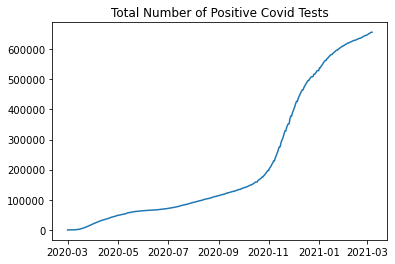

In [41]:
# Total Number of positive test in michigan
plt.plot(df['positive']);
plt.title('Total Number of Positive Covid Tests');

Definitely does not look like a stationary time-series.

# Check Stationarity

In [42]:
# Augmented Dickey-Fuller Weak-Sense Stationairty Test
adf(df['positive'])

non-stationary


In [43]:
# First Difference Transformation
df['dailyPosIncrease'] = df['positive'].diff() # Change in positive test

In [44]:
#  Augmented Dickey-Fuller Weak-Sense Stationairty Test
adf(df['dailyPosIncrease'].dropna())

non-stationary


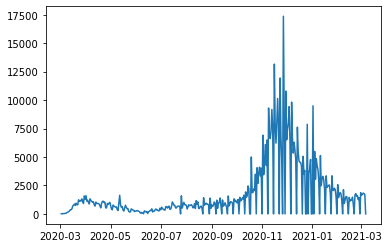

In [45]:
# Plot First Difference
plt.plot(df['dailyPosIncrease']);

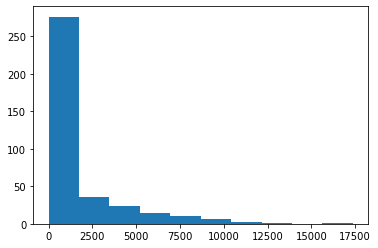

In [46]:
# Plot Histogram of First Difference
plt.hist(df['dailyPosIncrease']); #seems to be log normally distributed

Appears to be log normally distributed. Taking the second difference should result in a normal distribution.

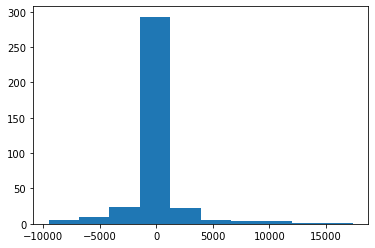

In [47]:
# Plot Hist of Second difference
plt.hist(df['dailyPosIncrease'].diff()); #Change in dailyPosIncrease

In [48]:
df['changeInDailyPosIncrease'] = df['dailyPosIncrease'].diff()

In [49]:
# Check if Second Difference result in Stationary Data    
adf(df['changeInDailyPosIncrease'].dropna())

 Pvalue = 0.00040117053361616976. data is stationary


# ACF/PACF Plots

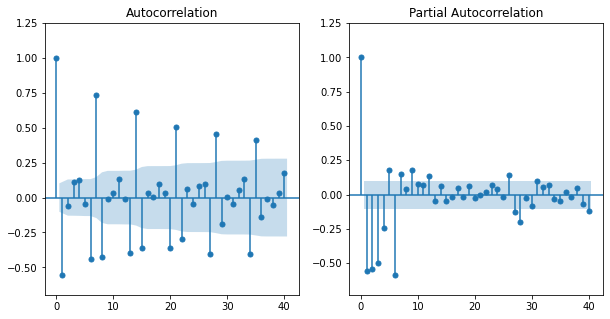

In [50]:
# ACF and PACF Red Flags
plot(df['changeInDailyPosIncrease'].dropna());

Erratic lag correlations in acf and pacf.

# Prep Training Data

In [51]:
Ntest = 50
train = df.iloc[:-Ntest][['changeInDailyPosIncrease']].dropna().copy()
test = df.iloc[-Ntest:][['changeInDailyPosIncrease']].dropna().copy()

In [52]:
m = train['changeInDailyPosIncrease'].mean()
s = train['changeInDailyPosIncrease'].std()
train['Scaled'] = (train['changeInDailyPosIncrease'] - m)/s
test['Scaled'] = (test['changeInDailyPosIncrease'] - m)/s
df['Scaled'] = (df['changeInDailyPosIncrease'] - m)/s

# ARCH(1) Model

In [53]:
arch1 = arch_model(train['Scaled'], vol='ARCH',p=1)

In [54]:
res_arch1 = arch1.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 1557.382874902579
Iteration:      2,   Func. Count:     13,   Neg. LLF: 1187.1161849853834
Iteration:      3,   Func. Count:     21,   Neg. LLF: 281.93071753159995
Iteration:      4,   Func. Count:     25,   Neg. LLF: 281.94885541715223
Iteration:      5,   Func. Count:     30,   Neg. LLF: 281.9275591180549
Iteration:      6,   Func. Count:     34,   Neg. LLF: 281.92755850989926
Optimization terminated successfully    (Exit mode 0)
            Current function value: 281.92755850989926
            Iterations: 6
            Function evaluations: 34
            Gradient evaluations: 6


In [55]:
res_arch1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 Scaled   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -281.928
Distribution:                  Normal   AIC:                           569.855
Method:            Maximum Likelihood   BIC:                           581.160
                                        No. Observations:                  320
Date:                Sun, Jun 05 2022   Df Residuals:                      319
Time:                        16:06:27   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0116  2.759e-02      0.421      0.674 [-4.246e-02,6.568e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1729  8.128e-02      2.127  3.345e-02 [1.355e-02,  0.332]
alpha[1]       1.0000      0.264      3.790  1.509e-04   [  0.483,  1.517]
==========================================================================

Covariance estimator: robust
"""

The volatility model has significant bias term and alpha[1] value. Hmm alpha value is one which means we will take 100% of the previous squared error + bias to predict the next value.

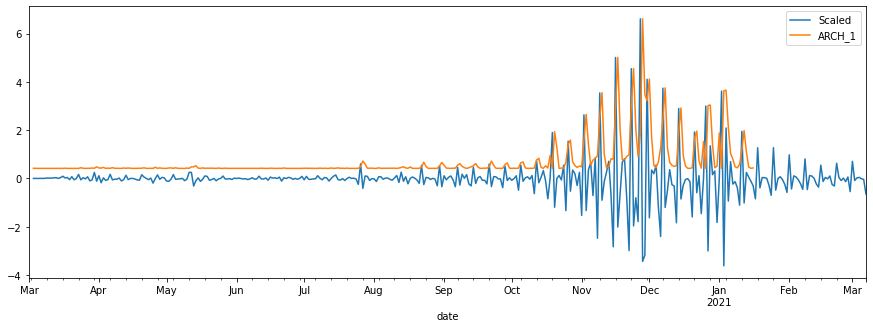

In [56]:
# Plot Scaled Data with the in-sample predicted conditional volatility
df['ARCH_1'] = res_arch1.conditional_volatility
df[['Scaled','ARCH_1']].plot(figsize=(15,5));

And the graph indeed appears to just copy previous values for the next prediction.

# Forecast and Plot

In [57]:
# Forecast with model based on specified start date
fcast_arch1 = res_arch1.forecast(
        horizon=Ntest,reindex=True,start= '2020-12-01')

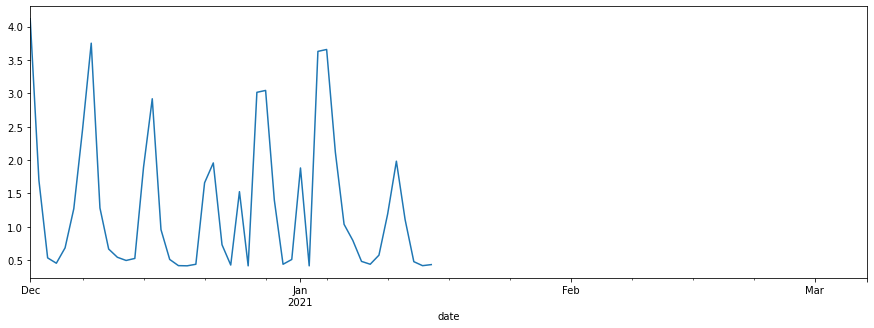

In [58]:
# We want to predict from here on out
df.loc['2020-12-01':]['ARCH_1'].plot(figsize=(15,5));

In [59]:
# Load the forecast into a new column for the forecast
df.loc['2020-12-02':'2021-01-20','ARCH_1_FORECAST'] = np.sqrt(
    fcast_arch1.variance.loc['2020-12-01'].to_numpy())

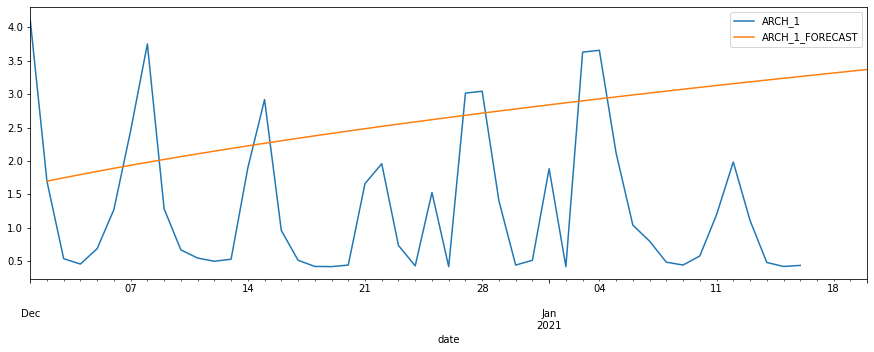

In [60]:
# Plot forecast with in-sample predicted conditional volatility
df.loc['2020-12-01':'2021-01-20'][['ARCH_1','ARCH_1_FORECAST']].plot(
    figsize=(15,5));

Hmm this does not appear to be converging like the stock returns example above. This forecast appears to be increasing over time.

In [61]:
# Model parameters 
res_arch1.params

mu          0.011610
omega       0.172865
alpha[1]    1.000000
Name: params, dtype: float64

In [62]:
# Unconditional Variance
res_arch1.params['omega'] / (1-res_arch1.params['alpha[1]'])

<ipython-input-62-6a808da56399>:2: RuntimeWarning: divide by zero encountered in double_scalars
  res_arch1.params['omega'] / (1-res_arch1.params['alpha[1]'])


inf

Infinite unconditional variance?

The alpha[1] value being 1 means we have a "Unit Root". Alpha is restricted to being between 0 and 1 because if it is larger than 1 or less than 0 we will either explode the squared error term or flip the value from positive to negative. This behavior points to your dataset being non-stationary. This is interesting because the ADF test we passed above was supposed to confirm the data we're using is stationary. This is however not the case which is also evident in the erratic ACF and PACF lag structures. In the future, I may explore the use of the IGARCH model to address the unit root.   